# Artificial Neural Networks and Deep Learning

---

## Lecture 8b: Transformer - Neural Machine Translation

<img src="https://drive.google.com/uc?export=view&id=1AVOts2Sq1sghbqmKpH0SBteeY0Ai-NHz" width="500"/>


## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Notebooks/TensorFlow/AN2DL/Lecture 8

## ⚙️ Import Libraries

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import keras.ops as ops
import seaborn as sns
import string
import re
import keras

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## 🧮 Define Hyperparameters

In [2]:
# Data processing parameters
vocab_size = 10000
sequence_length = 16
batch_size = 512

# Model architecture dimensions
embed_dim = 256
latent_dim = 512
num_heads = 4

# Layer configuration
num_encoder_layers = 2
num_decoder_layers = 2

# Print current parameters
print(f"Model parameters defined:\n"
      f"  Vocabulary size:    {vocab_size:>8,d}\n"
      f"  Sequence length:    {sequence_length:>8d}\n"
      f"  Batch size:         {batch_size:>8d}\n"
      f"  Embedding dim:      {embed_dim:>8d}\n"
      f"  Latent dim:         {latent_dim:>8d}\n"
      f"  Attention heads:    {num_heads:>8d}\n"
      f"  Encoder layers:     {num_encoder_layers:>8d}\n"
      f"  Decoder layers:     {num_decoder_layers:>8d}")

Model parameters defined:
  Vocabulary size:      10,000
  Sequence length:          16
  Batch size:              512
  Embedding dim:           256
  Latent dim:              512
  Attention heads:           4
  Encoder layers:            2
  Decoder layers:            2


## ⏳ Load and Process Data

In [3]:
# Set environment variables for Simple Translation dataset
os.environ["DATASET_NAME"] = "translation.txt"
os.environ["DATASET_URL"] = "1M9Kjftb0BiRNx_JwzKUzNmv8vjoHtizP"

# Check if Simple Translation dataset exists and download if not
if not os.path.exists(os.environ["DATASET_NAME"]):
    print("Downloading Simple Translation dataset...")
    !gdown -q ${DATASET_URL} -O ${DATASET_NAME}
    print("Simple Translation dataset downloaded!")
else:
    print("Simple Translation dataset already downloaded. Using cached data.")

Simple Translation dataset downloaded!


**Extract English-Italian sentence pairs and length statistics from parallel text file**

In [4]:

def read_txt(txt_file):
    # Initialise data structures
    sentence_pairs = []
    eng_lens = []
    ita_lens = []

    # Process file and extract sentence pairs
    with open(txt_file, encoding='utf-8') as file:
        for line in file:
            if '\t' in line:
                eng, ita = line.rstrip().split('\t')[:2]
                sentence_pairs.append([eng, f"[start] {ita} [end]"])
                eng_lens.append(len(eng.split()))
                ita_lens.append(len(ita.split()))

    # Print corpus statistics
    print(f"Corpus statistics:\n"
          f"  Sentence pairs:     {len(sentence_pairs):>8,d}\n"
          f"  Avg English length: {sum(eng_lens)/len(eng_lens):>8.2f}\n"
          f"  Avg Italian length: {sum(ita_lens)/len(ita_lens):>8.2f}")

    return sentence_pairs, {'eng_lens': eng_lens, 'ita_lens': ita_lens}

**Process parallel text corpus and visualise length distributions**

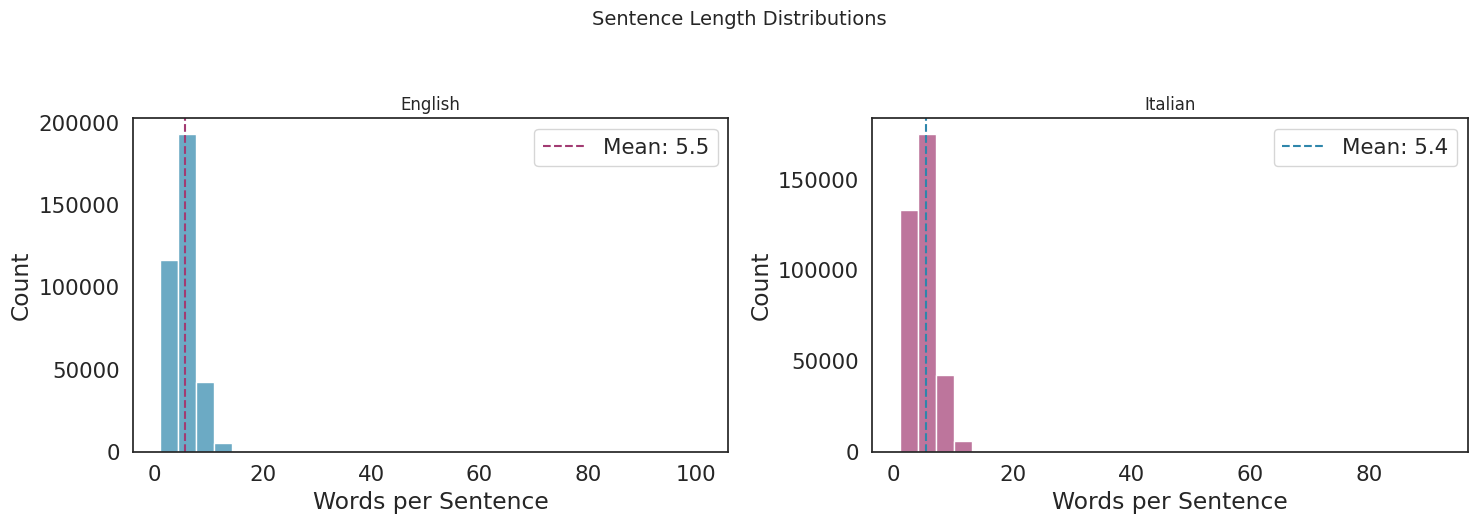


Distribution summary:
  Total pairs:         358,373
  Mean length (EN):        5.5
  Mean length (IT):        5.4

Random samples from corpus:

EN: Do you still have a key to Tom's apartment?
IT: [start] Voi avete ancora una chiave dell'appartamento di Tom? [end]

EN: Are they still mad?
IT: [start] Loro sono ancora arrabbiate? [end]

EN: I like to eat.
IT: [start] A me piace mangiare. [end]


In [5]:
def read_txt(txt_file):
    # Initialise data structures
    sentence_pairs = []
    eng_lens = []
    ita_lens = []

    # Process file and extract sentence pairs
    with open(txt_file, encoding='utf-8') as file:
        for line in file:
            if '\t' in line:
                eng, ita = line.rstrip().split('\t')[:2]
                sentence_pairs.append([eng, f"[start] {ita} [end]"])
                eng_lens.append(len(eng.split()))
                ita_lens.append(len(ita.split()))

    return sentence_pairs, {'eng_lens': eng_lens, 'ita_lens': ita_lens}

def visualize_lengths(eng_lens, ita_lens):
    # Configure visualisation parameters
    colors = ['#2E86AB', '#A23B72']

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('Sentence Length Distributions', fontsize=14, y=1.05)

    # Generate English distribution plot
    sns.histplot(eng_lens, ax=ax1, color=colors[0], alpha=0.7, bins=30)
    ax1.axvline(np.mean(eng_lens), color=colors[1], linestyle='--',
                label=f'Mean: {np.mean(eng_lens):.1f}')
    ax1.set_title('English', fontsize=12)
    ax1.set_xlabel('Words per Sentence')
    ax1.legend()

    # Generate Italian distribution plot
    sns.histplot(ita_lens, ax=ax2, color=colors[1], alpha=0.7, bins=30)
    ax2.axvline(np.mean(ita_lens), color=colors[0], linestyle='--',
                label=f'Mean: {np.mean(ita_lens):.1f}')
    ax2.set_title('Italian', fontsize=12)
    ax2.set_xlabel('Words per Sentence')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # Print distribution statistics
    print(f"\nDistribution summary:\n"
          f"  Total pairs:        {len(eng_lens):>8,d}\n"
          f"  Mean length (EN):   {np.mean(eng_lens):>8.1f}\n"
          f"  Mean length (IT):   {np.mean(ita_lens):>8.1f}")

# Load corpus and generate visualisations
text_pairs, stats = read_txt('translation.txt')
visualize_lengths(stats['eng_lens'], stats['ita_lens'])

# Display sample sentence pairs
print("\nRandom samples from corpus:")
for pair in random.sample(text_pairs, 3):
    print(f"\nEN: {pair[0]}\nIT: {pair[1]}")

**Partition dataset into training, validation and test sets**

In [6]:
# Randomise dataset order
random.shuffle(text_pairs)

# Calculate split sizes
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

# Split dataset into partitions
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

# Print partition sizes
print(f"Dataset partitions:\n"
      f"  Total samples:      {len(text_pairs):>8,d}\n"
      f"  Training samples:   {len(train_pairs):>8,d}\n"
      f"  Validation samples: {len(val_pairs):>8,d}\n"
      f"  Test samples:       {len(test_pairs):>8,d}")

Dataset partitions:
  Total samples:       358,373
  Training samples:    250,863
  Validation samples:   53,755
  Test samples:         53,755


**Configure text preprocessing and vectorisation parameters**

In [7]:
# Define character set for stripping
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Define text standardisation function
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

# Configure vectorisation layers
eng_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
ita_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

# Extract texts and adapt vectorisers
train_eng_texts = [pair[0] for pair in train_pairs]
train_ita_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ita_vectorization.adapt(train_ita_texts)

# Print vectorisation parameters
print(f"Vectorisation configuration:\n"
      f"  Vocabulary size:    {vocab_size:>8,d}\n"
      f"  Sequence length EN: {sequence_length:>8d}\n"
      f"  Sequence length IT: {sequence_length + 1:>8d}\n")

Vectorisation configuration:
  Vocabulary size:      10,000
  Sequence length EN:       16
  Sequence length IT:       17



**Create and format TensorFlow datasets for translation model training**

In [8]:
def format_dataset(eng, ita):
    # Vectorise input texts
    eng = eng_vectorization(eng)
    ita = ita_vectorization(ita)

    # Structure inputs and targets
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ita[:, :-1],
        },
        ita[:, 1:],
    )


def make_dataset(pairs):
    # Extract and convert text pairs
    eng_texts, ita_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ita_texts = list(ita_texts)

    # Create and configure dataset
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, ita_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)

    return dataset.cache().shuffle(2048).prefetch(16)


# Create train, validation and test datasets
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

# Print tensor shapes from sample batch
for inputs, targets in train_ds.take(1):
    print(f"Tensor shapes from sample batch:\n"
          f"  Encoder inputs:  {inputs['encoder_inputs'].shape}\n"
          f"  Decoder inputs:  {inputs['decoder_inputs'].shape}\n"
          f"  Target outputs:  {targets.shape}")

Tensor shapes from sample batch:
  Encoder inputs:  (512, 16)
  Decoder inputs:  (512, 16)
  Target outputs:  (512, 16)


## 🛠️ Transformer


<img src="https://drive.google.com/uc?export=view&id=1gIJ1TgvkZffX2yCL2DOUfA8lIN-UwD9f" width="400"/>

**Implement positional embeddings for transformer sequence encoding**

In [9]:
@keras.saving.register_keras_serializable(package="TransformerComponents")
class PositionalEmbedding(tfkl.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        # Initialise parent class
        super().__init__(**kwargs)

        # Configure token embedding layer
        self.token_embeddings = tfkl.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            mask_zero=True  # Enable automatic mask handling
        )

        # Store layer parameters
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Generate positional encoding matrix
        self.pos_encoding = self.get_positional_encoding(sequence_length, embed_dim)

    def get_positional_encoding(self, position, d_model):
        # Calculate position encoding as per transformer paper
        pos = np.arange(position)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))

        # Compute sinusoidal encoding components
        pe = np.zeros((position, d_model))
        pe[:, 0::2] = np.sin(pos * div_term)
        pe[:, 1::2] = np.cos(pos * div_term)

        return tf.cast(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, inputs):
        # Extract sequence length and embed tokens
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)

        # Apply positional encoding for current sequence length
        positional_encoding = self.pos_encoding[:, :length, :]

        return embedded_tokens + positional_encoding

    def get_config(self):
        # Enable layer serialisation
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

**Visualise positional encoding patterns from embedding layer**

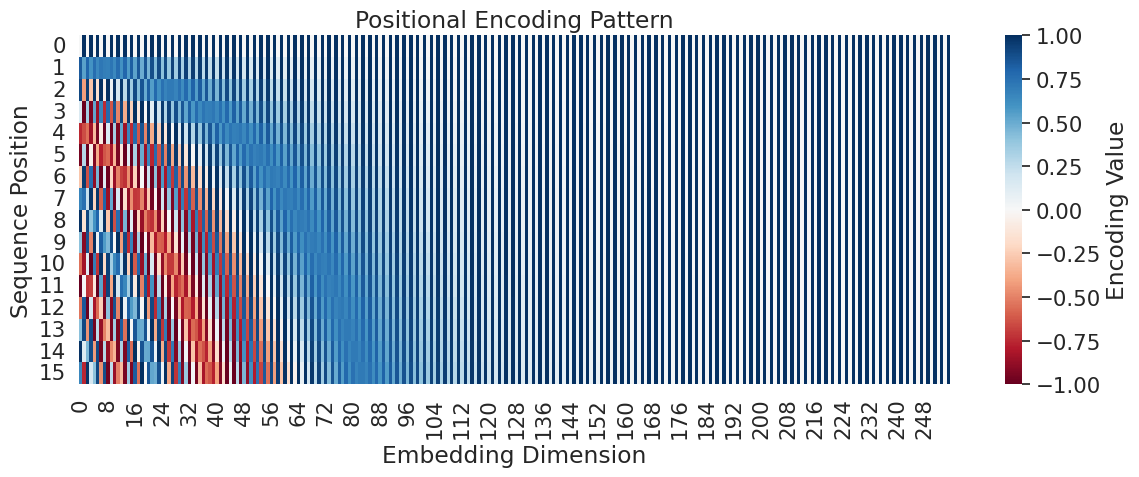

Encoding matrix dimensions:
  Sequence length:       16
  Embedding dimension:  256


In [10]:
def plot_positional_encoding(pe_layer, figsize=(12, 5)):
    # Extract encoding matrix
    pos_encoding = pe_layer.pos_encoding[0].numpy()

    # Configure visualisation parameters
    plt.figure(figsize=figsize)

    # Generate heatmap representation
    sns.heatmap(
        pos_encoding,
        cmap='RdBu',     # Red-blue diverging colormap
        center=0,        # Centre colormap at zero
        vmin=-1,        # Lower bound
        vmax=1,         # Upper bound
        cbar_kws={'label': 'Encoding Value'}
    )

    # Set plot aesthetics
    plt.title('Positional Encoding Pattern')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Sequence Position')
    plt.grid(False)

    plt.tight_layout()
    plt.show()

    # Print encoding dimensions
    print(f"Encoding matrix dimensions:\n"
          f"  Sequence length:     {pos_encoding.shape[0]:>4d}\n"
          f"  Embedding dimension: {pos_encoding.shape[1]:>4d}")

positional_embedding = PositionalEmbedding(sequence_length=sequence_length, vocab_size=vocab_size, embed_dim=embed_dim)
plot_positional_encoding(positional_embedding)

**Plot sinusoidal components of positional encoding across sequence positions**

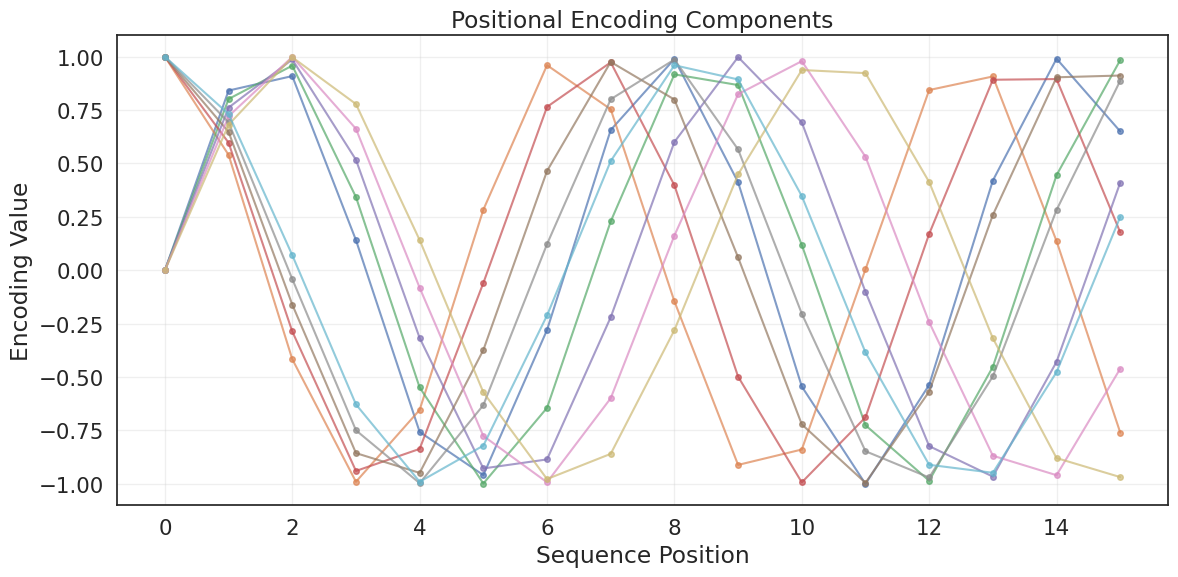

Component visualisation:
  Dimensions shown:      10
  Sequence positions:    16
  Value range:           -1.00 to   1.00


In [11]:
def plot_positional_encoding_components(pe_layer, num_dimensions=10, figsize=(12, 6)):
    # Extract encoding matrix
    pos_encoding = pe_layer.pos_encoding[0].numpy()

    # Configure visualisation parameters
    plt.figure(figsize=figsize)

    # Plot individual dimension curves
    for i in range(num_dimensions):
        plt.plot(
            pos_encoding[:, i],
            label=f'dim {i}',
            marker='o',
            markersize=4,
            alpha=0.7
        )

    # Set plot aesthetics
    plt.title('Positional Encoding Components')
    plt.xlabel('Sequence Position')
    plt.ylabel('Encoding Value')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print component statistics
    print(f"Component visualisation:\n"
          f"  Dimensions shown:    {num_dimensions:>4d}\n"
          f"  Sequence positions:  {pos_encoding.shape[0]:>4d}\n"
          f"  Value range:         {pos_encoding[:,:num_dimensions].min():>7.2f} to {pos_encoding[:,:num_dimensions].max():>6.2f}")

# Generate component plot
plot_positional_encoding_components(positional_embedding)

**Implement transformer encoder block with multi-head attention and feed-forward network**

In [12]:
@keras.saving.register_keras_serializable(package="TransformerComponents")
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, dropout_rate=0.1, **kwargs):
        # Initialise parent class
        super().__init__(**kwargs)

        # Store architecture parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # Configure multi-head attention mechanism
        self.attention = tfkl.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,  # Scale dimension per attention head
            dropout=dropout_rate
        )

        # Configure feed-forward network
        self.dense_proj = keras.Sequential([
            tfkl.Dense(dense_dim, activation="relu"),
            tfkl.Dropout(dropout_rate),
            tfkl.Dense(embed_dim)
        ])

        # Configure normalisation layers
        self.layernorm_1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tfkl.LayerNormalization(epsilon=1e-6)

        # Configure dropout for residual connections
        self.dropout_1 = tfkl.Dropout(dropout_rate)
        self.dropout_2 = tfkl.Dropout(dropout_rate)

        self.supports_masking = True

    def call(self, inputs, training=False, mask=None):
        # Apply pre-norm layer normalisation
        normalized_inputs = self.layernorm_1(inputs)

        # Process padding mask for attention
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
        else:
            padding_mask = None

        # Compute multi-head self-attention
        attention_output = self.attention(
            query=normalized_inputs,
            value=normalized_inputs,
            key=normalized_inputs,
            attention_mask=padding_mask,
            training=training
        )

        # Apply first residual connection
        attention_output = self.dropout_1(attention_output, training=training)
        first_residual = inputs + attention_output

        # Process through feed-forward network
        normalized_ffn = self.layernorm_2(first_residual)
        ffn_output = self.dense_proj(normalized_ffn)

        # Apply second residual connection
        ffn_output = self.dropout_2(ffn_output, training=training)
        return first_residual + ffn_output

    def get_config(self):
        # Enable layer serialisation
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate,
        })
        return config

**Implement transformer decoder block with masked self-attention and cross-attention mechanisms**

In [13]:
@keras.saving.register_keras_serializable(package="TransformerComponents")
class TransformerDecoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, dropout_rate=0.1, **kwargs):
        # Initialise parent class
        super().__init__(**kwargs)

        # Store architecture parameters
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim  # Feed-forward network dimension
        self.num_heads = num_heads
        self.dropout_rate = dropout_rate

        # Configure masked self-attention mechanism
        self.self_attention = tfkl.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,  # Scaled dimension per head
            dropout=dropout_rate
        )

        # Configure cross-attention for encoder outputs
        self.cross_attention = tfkl.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate
        )

        # Configure feed-forward network
        self.ffn = keras.Sequential([
            tfkl.Dense(ff_dim, activation="relu"),
            tfkl.Dropout(dropout_rate),
            tfkl.Dense(embed_dim),
            tfkl.Dropout(dropout_rate)
        ])

        # Configure normalisation layers
        self.layernorm_1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm_2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm_3 = tfkl.LayerNormalization(epsilon=1e-6)

        # Configure dropout layers
        self.dropout_1 = tfkl.Dropout(dropout_rate)
        self.dropout_2 = tfkl.Dropout(dropout_rate)
        self.dropout_3 = tfkl.Dropout(dropout_rate)

        self.supports_masking = True

    def call(self, inputs, training=None):
        # Unpack inputs and encoder outputs
        inputs, encoder_outputs = inputs

        # Generate causal mask for autoregressive attention
        causal_mask = self.get_causal_attention_mask(inputs)

        # Apply masked self-attention
        attention_output_1 = self.self_attention(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
            training=training
        )
        attention_output_1 = self.dropout_1(attention_output_1, training=training)
        out1 = self.layernorm_1(inputs + attention_output_1)

        # Apply cross-attention with encoder outputs
        attention_output_2 = self.cross_attention(
            query=out1,
            value=encoder_outputs,
            key=encoder_outputs,
            training=training
        )
        attention_output_2 = self.dropout_2(attention_output_2, training=training)
        out2 = self.layernorm_2(out1 + attention_output_2)

        # Process through feed-forward network
        ffn_output = self.ffn(out2, training=training)
        ffn_output = self.dropout_3(ffn_output, training=training)
        return self.layernorm_3(out2 + ffn_output)

    def get_causal_attention_mask(self, inputs):
        # Generate lower triangular mask for autoregressive attention
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, None]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, sequence_length, sequence_length))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def get_config(self):
        # Enable layer serialisation
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "ff_dim": self.ff_dim,
            "num_heads": self.num_heads,
            "dropout_rate": self.dropout_rate
        })
        return config

**Construct transformer model for sequence-to-sequence tasks**

In [14]:
def build_transformer(
    vocab_size,
    sequence_length,
    embed_dim=128,
    latent_dim=1024,
    num_heads=4,
    num_encoder_layers=2,
    num_decoder_layers=2,
    name="transformer"
):
    # Configure encoder architecture
    encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)

    # Process through encoder blocks
    for _ in range(num_encoder_layers):
        x = TransformerEncoderBlock(embed_dim, latent_dim, num_heads)(x)
    encoder_outputs = x

    # Create encoder model
    encoder = keras.Model(encoder_inputs, encoder_outputs)

    # Configure decoder architecture
    decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
    encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")

    # Apply positional embedding to decoder inputs
    x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)

    # Process through decoder blocks
    for _ in range(num_decoder_layers):
        x = TransformerDecoderBlock(embed_dim, latent_dim, num_heads)([x, encoder_outputs])

    # Generate output probabilities
    decoder_outputs = tfkl.Dense(vocab_size, activation="softmax")(x)
    decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

    # Construct complete transformer model
    transformer = keras.Model(
        {
            "encoder_inputs": encoder_inputs,
            "decoder_inputs": decoder_inputs
        },
        decoder_outputs,
        name=name
    )

    # Print model architecture summary
    print(f"Transformer architecture:\n"
          f"  Vocabulary size:    {vocab_size:>8,d}\n"
          f"  Sequence length:    {sequence_length:>8d}\n"
          f"  Embedding dim:      {embed_dim:>8d}\n"
          f"  Latent dim:         {latent_dim:>8d}\n"
          f"  Attention heads:    {num_heads:>8d}\n"
          f"  Encoder layers:     {num_encoder_layers:>8d}\n"
          f"  Decoder layers:     {num_decoder_layers:>8d}")

    return transformer, encoder, decoder

**Instantiate transformer model components with hyperparameters**

Transformer architecture:
  Vocabulary size:      10,000
  Sequence length:          16
  Embedding dim:           256
  Latent dim:              512
  Attention heads:           4
  Encoder layers:            2
  Decoder layers:            2


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ encoder_inputs         │ (None, None)         │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ positional_embedding_1 │ (None, None, 256)    │    2,560,000 │ encoder_inputs[0][… │    Y    │
│ (PositionalEmbedding)  │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ decoder_inputs         │ (None, None)         │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ transformer_encoder_b… │ (None, None, 256)    │      527,104 │ positional_embeddi… │    Y    │
│ (TransformerEncoderBl… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ positional_embedding_2 │ (None, None, 256)    │    2,560,000 │ decoder_inputs[0][… │    Y    │
│ (PositionalEmbedding)  │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ transformer_encoder_b… │ (None, None, 256)    │      527,104 │ transformer_encode… │    Y    │
│ (TransformerEncoderBl… │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ transformer_decoder_b… │ (None, None, 256)    │      790,784 │ positional_embeddi… │    Y    │
│ (TransformerDecoderBl… │                      │              │ transformer_encode… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ transformer_decoder_b… │ (None, None, 256)    │      790,784 │ transformer_decode… │    Y    │
│ (TransformerDecoderBl… │                      │              │ transformer_encode… │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ dense_8 (Dense)        │ (None, None, 10000)  │    2,570,000 │ transformer_decode… │    Y    │
└────────────────────────┴──────────────────────┴──────────────┴─────────────────────┴─────────┘

 Total params: 10,325,776 (39.39 MB)

 Trainable params: 10,325,776 (39.39 MB)

 Non-trainable params: 0 (0.00 B)

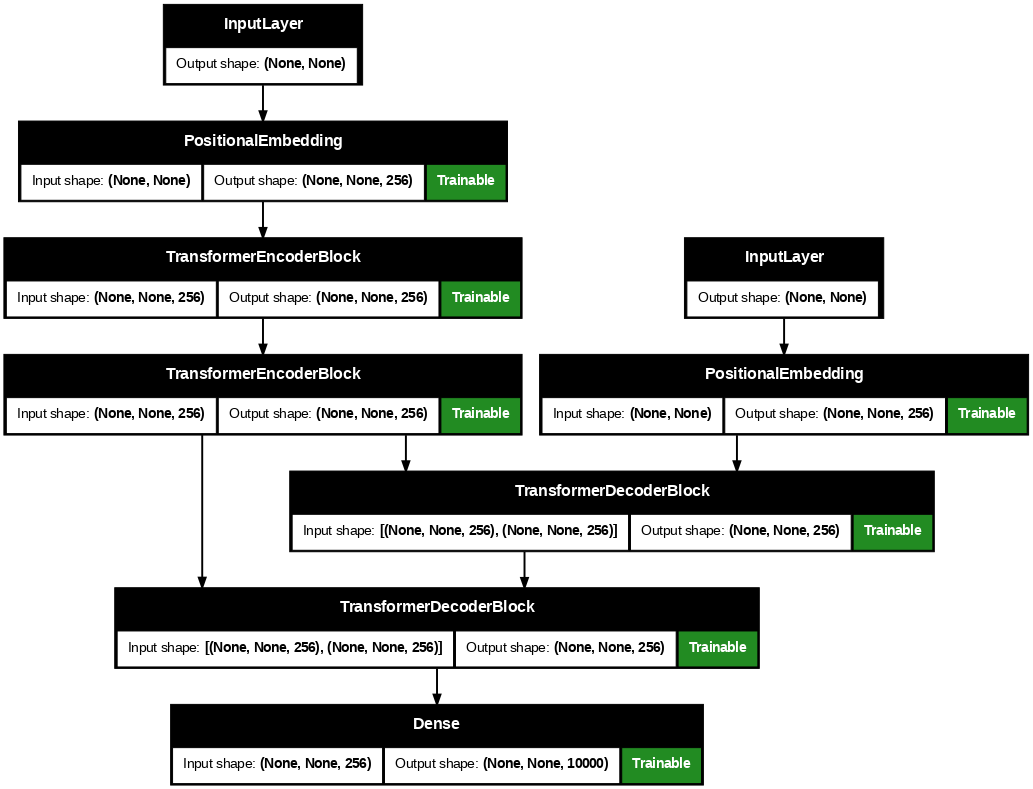

In [15]:
transformer, encoder, decoder = build_transformer(
    vocab_size=vocab_size,
    sequence_length=sequence_length,
    embed_dim=embed_dim,
    latent_dim=latent_dim,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers
)

# Display model information
transformer.summary(expand_nested=True, show_trainable=True)

# Create visual representation
tf.keras.utils.plot_model(
    transformer,
    show_trainable=True,
    expand_nested=True,
    dpi=70,
    show_shapes=True
)

**Configure training parameters and compile transformer model**

In [16]:
# Initialise Adam optimiser with default parameters
optimizer = tfk.optimizers.Adam()

# Configure model with loss function and metrics
transformer.compile(
    optimizer=optimizer,
    loss=tfk.losses.SparseCategoricalCrossentropy(ignore_class=0),  # Ignore padding tokens
    metrics=['accuracy']
)

# Print training configuration
print(f"Training configuration:\n"
      f"  Optimiser:          Adam\n"
      f"  Learning rate:      {optimizer.learning_rate.numpy():>8.2e}\n"
      f"  Loss function:      Sparse Categorical Cross-entropy\n"
      f"  Metrics:            Accuracy")

Training configuration:
  Optimiser:          Adam
  Learning rate:      1.00e-03
  Loss function:      Sparse Categorical Cross-entropy
  Metrics:            Accuracy


**Train transformer model with early stopping and learning rate adaptation**

In [17]:
# Configure training callbacks
callbacks = [
    # Monitor validation accuracy for early stopping
    tfk.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Adjust learning rate based on performance
    tfk.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=3,
        min_lr=1e-6,
        mode='max',
        verbose=1
    )
]

# Print training parameters
print(f"Training configuration:\n"
      f"  Maximum epochs:     {100:>8d}\n"
      f"  Early stop patience:{5:>8d}\n"
      f"  LR reduce patience: {3:>8d}\n"
      f"  Minimum LR:         {1e-6:>8.0e}")

# Execute training process
history = transformer.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
).history

# Evaluate model performance
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f"\nTraining results:\n"
      f"  Final validation accuracy: {final_val_accuracy:>8.2f}%\n"
      f"  Total epochs trained:      {len(history['accuracy']):>8d}")

# Save trained model
model_filename = f'transformer_seq2seq_{final_val_accuracy}.keras'
transformer.save(model_filename)
print(f"  Model saved as:            {model_filename}")

# Release model resources
del transformer

Training configuration:
  Maximum epochs:          100
  Early stop patience:       5
  LR reduce patience:        3
  Minimum LR:            1e-06
Epoch 1/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 138s 202ms/step - accuracy: 0.1100 - loss: 4.9040 - val_accuracy: 0.2452 - val_loss: 1.8639 - learning_rate: 0.0010
Epoch 2/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 76s 122ms/step - accuracy: 0.2499 - loss: 1.7417 - val_accuracy: 0.2918 - val_loss: 1.0778 - learning_rate: 0.0010
Epoch 3/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 59s 121ms/step - accuracy: 0.2888 - loss: 1.0776 - val_accuracy: 0.3039 - val_loss: 0.8829 - learning_rate: 0.0010
Epoch 4/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - accuracy: 0.3023 - loss: 0.8632 - val_accuracy: 0.3108 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 5/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 81s 123ms/step - accuracy: 0.3098 - loss: 0.7544 - val_accuracy: 0.3138 - val_loss: 0.7434 - learning_rate: 0.0010
Epoch 6/100
490/490 ━━━━━━━━━━━━━━━━━━━━ 61s 124ms/step - accuracy: 0.3

**Visualise training history with loss and accuracy metrics**

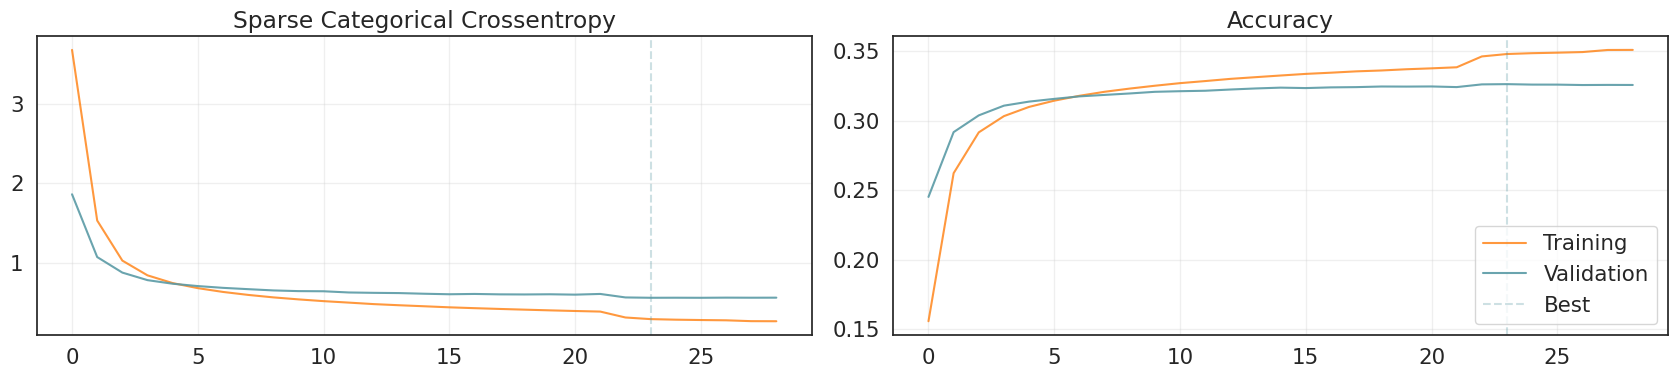

In [18]:
# Identify epoch with highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Configure figure layout
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 4))

# Generate loss history plot
ax1.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
ax1.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
ax1.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
ax1.set_title('Sparse Categorical Crossentropy')
ax1.grid(alpha=.3)

# Generate accuracy history plot
ax2.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation', alpha=.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best', alpha=.3, ls='--', color='#5a9aa5')
ax2.set_title('Accuracy')
ax2.grid(alpha=.3)

# Configure legend and layout
ax2.legend(loc='lower right')
plt.tight_layout()

# Display visualisation
plt.show()

## 🕹️ Use the Model - Make Inference

In [20]:
# Load the saved transformer model
loaded_transformer = tfk.models.load_model('transformer_seq2seq_32.63.keras')

**Perform English to Italian translation using a transformer model**

In [21]:
# Initialise vocabulary and lookup dictionaries
ita_vocab = ita_vectorization.get_vocabulary()
ita_index_lookup = dict(zip(range(len(ita_vocab)), ita_vocab))

# Set maximum length for decoded sentences
max_decoded_sentence_length = 20

# Define sequence decoder function
def decode_sequence(input_sentence):
    # Vectorise input English sentence
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"

    # Generate translation token by token
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ita_vectorization([decoded_sentence])[:, :-1]

        # Generate predictions using transformer
        predictions = loaded_transformer(
            {
                "encoder_inputs": tokenized_input_sentence,
                "decoder_inputs": tokenized_target_sentence,
            }
        )

        # Select highest probability token
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = ita_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Break if end token is generated
        if sampled_token == "[end]":
            break

    return decoded_sentence


# Test translation on random samples
test_eng_texts = [pair[0] for pair in test_pairs]

# Print sample translations
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(f"English:  {input_sentence}\nItalian:  {translated}\n")

English:  How many times has Tom been here?
Italian:  [start] quante volte è stata qui tom [end]

English:  Tom killed three enemy soldiers.
Italian:  [start] tom ha ucciso tre soldati nemici [end]

English:  Stop complaining about the weather.
Italian:  [start] smettila di lamentarti del tempo [end]

English:  I don't think that'll happen.
Italian:  [start] non penso che succederà [end]

English:  Tom isn't hungry.
Italian:  [start] tom non ha fame [end]

English:  Tom works as a bouncer.
Italian:  [start] tom lavora come [UNK] [end]

English:  That's your loss.
Italian:  [start] È la tua perdita [end]

English:  You've grown so tall.
Italian:  [start] sei troppo alto [end]

English:  Did you see Tom that night?
Italian:  [start] avete visto tom quella notte [end]

English:  I've been sentenced to death.
Italian:  [start] sono stata [UNK] a morte [end]



**Translate input text using sequence decoder**

In [22]:
# Define input text
sentence = "The lecture is finished!"

# Process text through decoder
translated = decode_sequence(sentence)

# Print original and translated text
print(f"Original text:  {sentence}\nTranslated text: {translated}")

Original text:  The lecture is finished!
Translated text: [start] la lezione è finita [end]


<img src="https://drive.google.com/uc?export=view&id=1l9nX1i4nSj3gB1GD0t8Nbhh6MPHJE7mO" width="500"/>